In [90]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression

from datetime import datetime, timedelta
# from causallib.estimation import IPW

In [2]:
#from rmsn.script_rnn_predict import rnn_predict
from feature_engineer import Feature_Engineering
from utils.evaluation_utils import load_data
import copy
import gc

In [3]:
import os

In [10]:
from ale import ale_plot
from rmsn.script_rnn_predict import rnn_predict

2024-05-16 15:22:56.186123: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 15:22:56.234103: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 15:22:56.833849: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2024-05-16 15:22:57.417147: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46527 MB memory:  -> device: 0, name: NVIDIA L20, pci bus id: 0000:69:01.0, compute capability: 8.9
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Number of devices: 1


# 1. 直接调compute_ale方法

In [8]:
import h5py
with h5py.File('../data/sample_32w.h5', 'r') as f:
    print(list(f.keys()))
    f.close()

['covariates', 'outcomes', 'sequence_length', 'treatments']


In [4]:
# treatments
dataset = load_data("../data/sample_32w.h5")
def obtain_dataset(dataset, column_index, selection=1):
        dataset_part = {}
        selected_indices = np.where(dataset['covariates'][:, :, column_index] == selection)[0]
        unique_selected_indices = np.unique(selected_indices)
        for key in dataset.keys():
            dataset_part[key] = dataset[key][unique_selected_indices]
        return dataset_part

column_2019 = 12  # index of year 2019 indicator
column_2020 = 13  # index of year 2020 indicator
column_2023 = 14  # index of year 2023 indicator

#dataset19 = obtain_dataset(dataset, column_2019)['treatments'][:,:,0]
#dataset20 = obtain_dataset(dataset, column_2020)['treatments'][:,:,0]
#dataset23 = obtain_dataset(dataset, column_2023)['treatments'][:,:,0]

dataset19 = obtain_dataset(dataset, column_2019)
dataset20 = obtain_dataset(dataset, column_2020)
dataset23 = obtain_dataset(dataset, column_2023)

In [6]:
def compute_ale(dataset, model_name, b_use_predicted_confounders, features):
    # compute accumulated local effects (ALE)
    model_name = model_name + '_use_confounders_' + str(b_use_predicted_confounders)
    model_root = os.path.join('results', model_name)
    # config = {'covariate_cols':['gender','age','income','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4', 'weekday_5', 'weekday_6',
    #               'voluntary','festivals','year_0','year_1','year_2','edu','married','dist_yes','density', 'spatial_ent','temperal_ent','flow','temperature','percipit'],
    #          'treatment_cols':['conformity','E1','E2'],
    #          'confounder_cols':['confounder_{}'.format(i) for i in range(dataset['predicted_confounders'].shape[2])]}
    #config = {'covariate_cols':['gender','age','income','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4', 'weekday_5', 'weekday_6',
    #            'voluntary','festivals','year_0','year_1','year_2','density','landusemix','road_density','center','subway','edu',
    #            'married','dist_yes','temperature','percipit'],
    #        'treatment_cols':['conformity','E1','E2'],
    #        'confounder_cols':['confounder_{}'.format(i) for i in range(dataset['predicted_confounders'].shape[2])]
    #        }
    config = {'covariate_cols':['gender','age','income','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4', 'weekday_5', 'weekday_6',
            'voluntary','festivals','year_0','year_1','year_2','density','edu',
            'married','dist_yes','temperature','percipit','E1','E2'],
        'treatment_cols':['conformity'],
       }
    # config = {'covariate_cols':['gender','age','income','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4', 'weekday_5', 'weekday_6',
    #             'voluntary','festivals','year_0','year_1','year_2','density','edu',
    #             'married','dist_yes','temperature','percipit'],
    #         'treatment_cols':['conformity','E1','E2'],
    #         'confounder_cols':['confounder_{}'.format(i) for i in range(dataset['predicted_confounders'].shape[2])]
    #         }
    #config = {'covariate_cols':['gender','age','income','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4', 'weekday_5', 'weekday_6',
    #        'voluntary','festivals','year_0','year_1','year_2','edu','married','dist_yes','density',
    #                        'entropy','temperature','percipit','E1','E2'],
    #         'treatment_cols':['conformity'],
    # }
    
    # shape of data
    num_samples, length, num_covariates = dataset['covariates'].shape
    _, _, num_treatments = dataset['treatments'].shape
    ## 先计算标准化的参数
    #scale_params = get_normalize_params(dataset, num_covariates, num_treatments)
    #dataset['output_means'] = scale_params['outcomes'][:, 0]
    #dataset['output_stds'] = scale_params['outcomes'][:, 1]
    
    ## construct dataframe
    #all_data = np.concatenate((dataset['covariates'].reshape(-1, len(config['covariate_cols'])), \
    #    dataset['treatments'].reshape(-1, len(config['treatment_cols']))), axis=1)
    #all_data = np.concatenate((all_data, dataset['predicted_confounders'].reshape(-1, len(config['confounder_cols']))), axis=1)
    #all_cols = config['covariate_cols'] + config['treatment_cols'] + config['confounder_cols']

    #X = pd.DataFrame(all_data, columns=all_cols)
    FE_predict = Feature_Engineering(dataset, for_factor_model = False)
    X = FE_predict.construct_dataframe(config)
    dataset['output_means'] = FE_predict.scale_params['outcomes'][:, 0]
    dataset['output_stds'] = FE_predict.scale_params['outcomes'][:, 1]
    # add timeline and week column
    X['timeline'] = np.tile(np.arange(length), num_samples)
    # start_date = pd.Timestamp('2020-01-01')
    # X['week'] = X['timeline'].apply(lambda x: start_date + pd.Timedelta(days=x)).dt.week - 1
    # 20年的数据是从2019.12.21开始的，直接按7天编码
    start_date = pd.Timestamp('2019-12-21')
    X['date'] = X['timeline'].apply(lambda x: start_date + pd.Timedelta(days=x))
    using_policy_period = False
    if using_policy_period:
        # 按政策时期分类
        # Define the dates to categorize
        categorization_dates = pd.to_datetime(
            ['2020-01-19','2020-01-23', '2020-02-07', '2020-02-10', '2020-02-17', '2020-02-23', '2020-03-21', '2020-03-29', '2020-05-09']
        )
        # Function to categorize dates
        def categorize_date(row_date):
            for i, cat_date in enumerate(categorization_dates):
                if row_date < cat_date:
                    return i
            return len(categorization_dates)
        X['week'] = X['date'].apply(categorize_date)
    else:
         X['week'] = ((X['date'] - start_date).dt.days / 7).astype(int)
    
    # # 确保周编号在年末时正确地重置
    # X['year'] = X['timeline'].apply(lambda x: start_date + pd.Timedelta(days=x)).dt.year
    # X['week'] = X.apply(lambda row: row['week'] + 52* (row['year'] - 2020), axis=1) # mistake

    ##############################################################################################################
    def ale_use_predict(X, dataset, config, model_root, FE_predict, b_use_predicted_confounders):
        # change data
        mod_dataset = dataset.copy()
        # 将修改完的值添加到mod_dataset
        covariate_shapes = dataset['covariates'].shape
        mod_dataset['covariates'] = X[config['covariate_cols']].values.reshape(covariate_shapes[0],covariate_shapes[1],covariate_shapes[2])
        treatment_shapes = dataset['treatments'].shape
        mod_dataset['treatments'] = X[config['treatment_cols']].values.reshape(treatment_shapes[0],treatment_shapes[1],treatment_shapes[2])
        
        # 使用原来的参数做标准化
        mod_dataset = FE_predict.get_dataset_normalize(mod_dataset, num_covariates, num_treatments)
        # 调用函数预测
        predictions, _ = \
        rnn_predict(dataset=mod_dataset, MODEL_ROOT=model_root,
                    b_use_predicted_confounders=b_use_predicted_confounders)
        outputs = predictions.reshape(-1)
        del mod_dataset; gc.collect()
        return outputs
    ##############################################################################################################
    
    # define predictor
    predictor = lambda x: ale_use_predict(x, dataset, config, model_root, FE_predict, b_use_predicted_confounders)

    # Plots ALE function of specified features based on training set.
    # if len(features)==1:
    #     ale_fig, ale_ax = ale_plot(
    #                 None, 
    #                 X,
    #                 features,
    #                 bins=20,
    #                 predictor=predictor,
    #                 monte_carlo=True,
    #                 monte_carlo_rep=100,
    #                 monte_carlo_ratio=0.6,)
    # else:
    ale_fig, ale_ax, ale = ale_plot(
                None, 
                X,
                features,
                bins=20,
                predictor=predictor,)

    return ale_fig, ale

In [9]:
#exp_name = 'base_model_optimal'
#single_ale_fig, ale = compute_ale(dataset19, 'rmsn_' + str(exp_name), b_use_predicted_confounders=False, features=['conformity'])


# 2. 使用ALE值绘图

### 2.1 rmsn_all_data_2020_use_confounders_True

In [23]:
ale = np.load("../data/result_data/week_ale_2020_deconfound.npy")

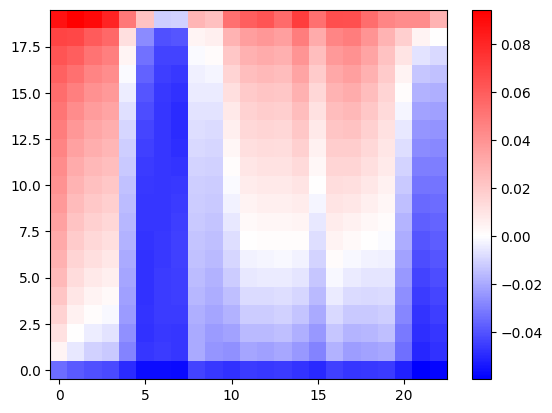

In [12]:
# 找出最小值和最大值
min_val = np.min(ale)
max_val = np.max(ale)
midpoint = abs(min_val) / (abs(max_val) + abs(min_val))

colors = [(0, "blue"), (midpoint, "white"), (1, "red")]
linear_cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors)

HM = plt.imshow(ale.T, aspect='auto', cmap=linear_cmap, origin='lower', vmin=min_val, vmax=max_val)
fig.colorbar(HM)

Text(0.5, 1.0, 'year 2020 deconfounder_log_axis')

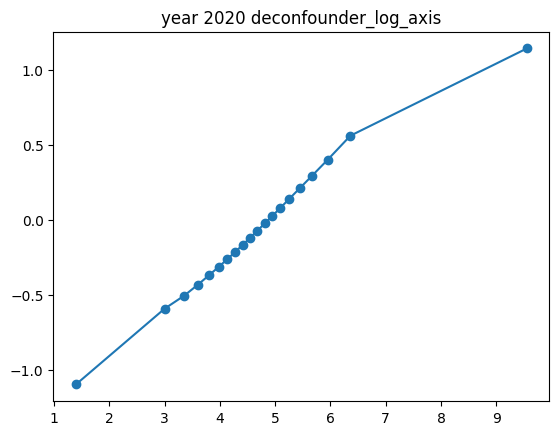

In [24]:
ale_1st = np.sum(ale, axis=0)
# quantiles = [1.6114013, 3.4510883, 3.82506155, 4.08184605, 4.2853105, 4.45873335, 4.61313055, 4.7550869, 4.88978745, 5.02060375, 5.1493648, 5.2790738, 5.413704, 5.555795, 5.7097233, 5.8846348, 6.094742, 6.36250865, 6.74445625, 10.4836711]
# quantiles = [1.6949405, 3.60569815, 3.9546319, 4.1883361, 4.37220835, 4.52908, 
#             4.6693283, 4.7996843, 4.924788, 5.047324, 5.1707917, 5.29837155, 
#             5.43314035, 5.5797785, 5.744631, 5.9346547, 6.1610155, 6.4437378, 
#             6.84756265, 10.32526115]
quantiles = [1.3919743, 2.9971027, 3.3512206, 3.6021075, 3.8045802, 3.9785473, 4.1340814, 4.27761, 4.4141173, 4.5467253, 4.677453, 4.8095093, 4.9464726, 5.0927362, 5.254286, 5.44032, 5.6650457, 5.9527235, 6.360175, 9.553446]
plt.scatter(quantiles, ale_1st)
plt.plot(quantiles, ale_1st)
plt.title("year 2020 deconfounder_log_axis")

Text(0.5, 1.0, 'year 2020 deconfounder_numerical_axis')

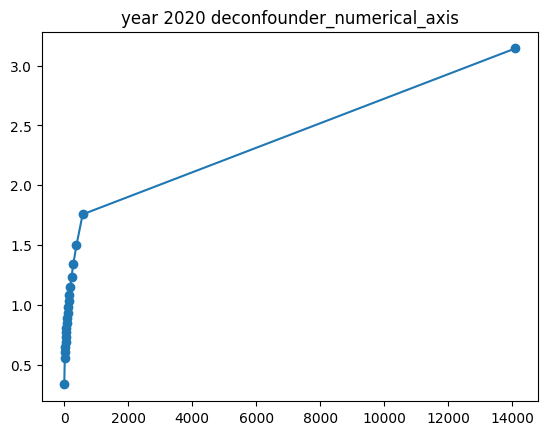

In [28]:
plt.scatter(np.exp(quantiles)-1, np.exp(ale_1st))
plt.plot(np.exp(quantiles)-1, np.exp(ale_1st))
plt.title("year 2020 deconfounder_numerical_axis")

Text(0.5, 1.0, 'year 2020 deconfounder_cut_5%_95%')

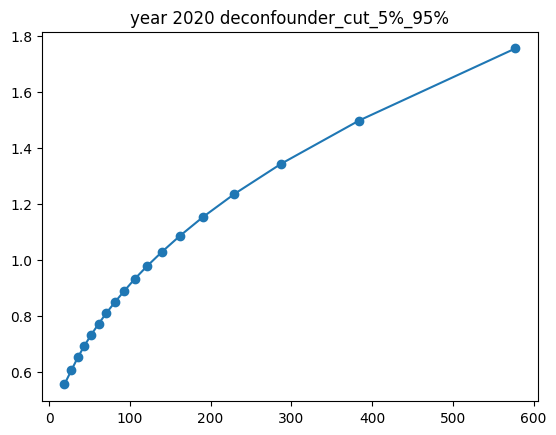

In [27]:
quantiles_cut = quantiles[1:-1]
ale_1st_cut = ale_1st[1:-1]
plt.scatter(np.exp(quantiles_cut)-1, np.exp(ale_1st_cut))
plt.plot(np.exp(quantiles_cut)-1, np.exp(ale_1st_cut))
plt.title("year 2020 deconfounder_cut_5%_95%")

### 2.2 rmsn_base_model_optimal_v2_use_confounders_False

In [93]:
# 将三张ALE画在一起（用同一颜色条）
ale_19 = np.load("../data/result_data/week_ale_2019_base_optimal_v2.npy")
ale_20 = np.load("../data/result_data/week_ale_2020_base_optimal_v2.npy")
ale_23 = np.load("../data/result_data/week_ale_2023_base_optimal_v2.npy")

In [68]:
# 将数组连接在一起
combined_array = np.concatenate([ale_19,ale_20,ale_23])

# 找出最小值和最大值
min_val = np.min(combined_array)
max_val = np.max(combined_array)
midpoint = abs(min_val) / (abs(max_val) + abs(min_val))

colors = [(0, "blue"), (midpoint, "white"), (1, "red")]
linear_cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors)

Text(0.5, 1.0, 'Heatmap_model2')

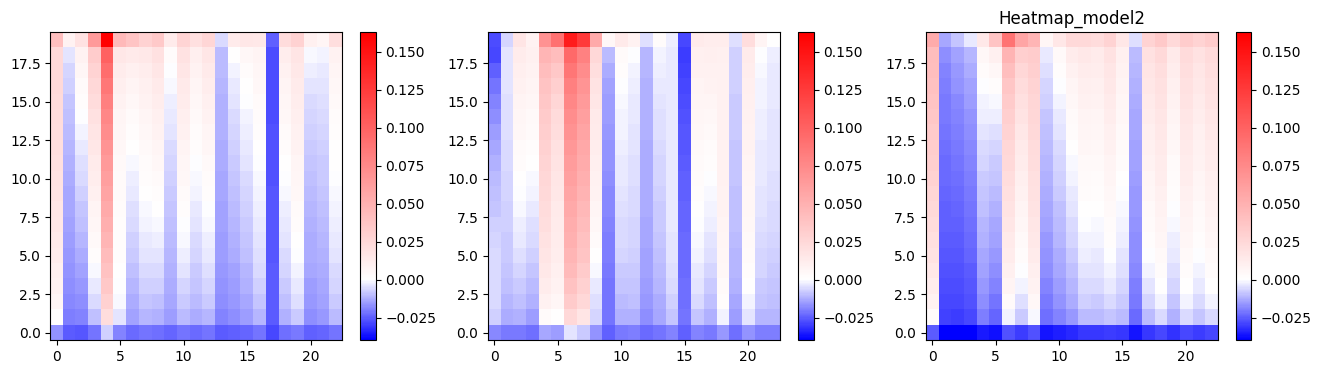

In [72]:
fig, ax = plt.subplots(1,3,figsize=(16,4))
HM_2019 = ax[0].imshow(ale_19.T, aspect='auto', cmap=linear_cmap, origin='lower', vmin=min_val, vmax=max_val)
HM_2020 = ax[1].imshow(ale_20.T, aspect='auto', cmap=linear_cmap, origin='lower', vmin=min_val, vmax=max_val)
HM_2023 = ax[2].imshow(ale_23.T, aspect='auto', cmap=linear_cmap, origin='lower', vmin=min_val, vmax=max_val)
fig.colorbar(HM_2019)
fig.colorbar(HM_2020)
fig.colorbar(HM_2023)
plt.title("Heatmap_model2")

In [94]:
quantiles =[[1.6942899, 3.604688, 3.9550974, 4.1904836, 4.3753552, 4.5325994, 4.673237, 4.8040957, 4.929389, 5.0522227, 5.175479, 5.301791, 5.435109, 5.5802326, 5.7425194, 5.9301834, 6.155841, 6.4387674, 6.8431473, 10.6669035],
           [1.3919743, 2.9971027, 3.3512206, 3.6021075, 3.8045802, 3.9785473, 4.1340814, 4.27761, 4.4141173, 4.5467253, 4.677453, 4.8095093, 4.9464726, 5.0927362, 5.254286, 5.44032, 5.6650457, 5.9527235, 6.360175, 9.553446],
           [1.9707608, 4.1234283, 4.4188213, 4.618977, 4.778722, 4.916623, 5.0410566, 5.1569986, 5.267918, 5.3763404, 5.4842725, 5.5940084, 5.7085733, 5.8315067, 5.9683475, 6.1289196, 6.326209, 6.580548, 6.94853, 10.013065],
           ]
ale_19_1st = np.sum(ale_19, axis=0)
ale_20_1st = np.sum(ale_20, axis=0)
ale_23_1st = np.sum(ale_23, axis=0)

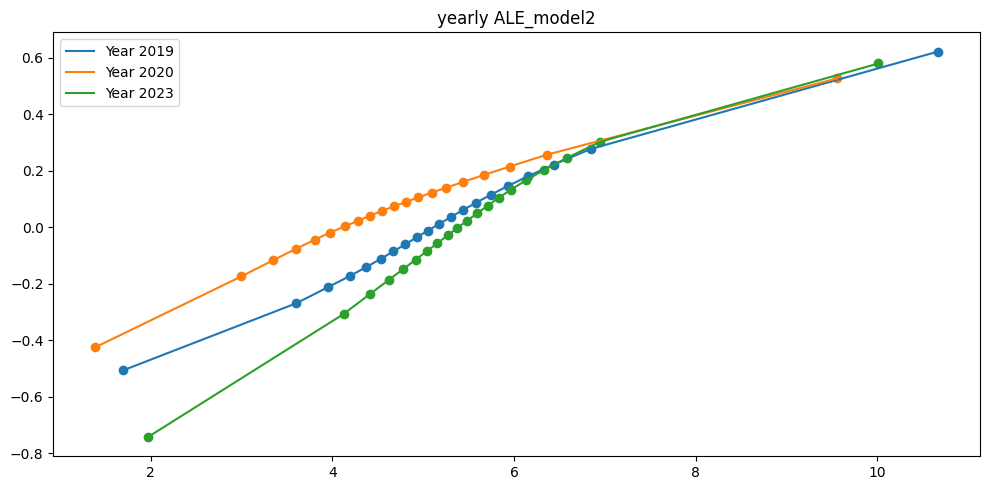

In [74]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(quantiles[0], ale_19_1st, label='Year 2019')
ax.plot(quantiles[1], ale_20_1st, label='Year 2020')
ax.plot(quantiles[2], ale_23_1st, label='Year 2023')

ax.scatter(quantiles[0], ale_19_1st)
ax.scatter(quantiles[1], ale_20_1st)
ax.scatter(quantiles[2], ale_23_1st)


# ax.set_ylim([-0.11,0.05])
ax.legend()

plt.title("yearly ALE_model2")
plt.tight_layout()
plt.show()

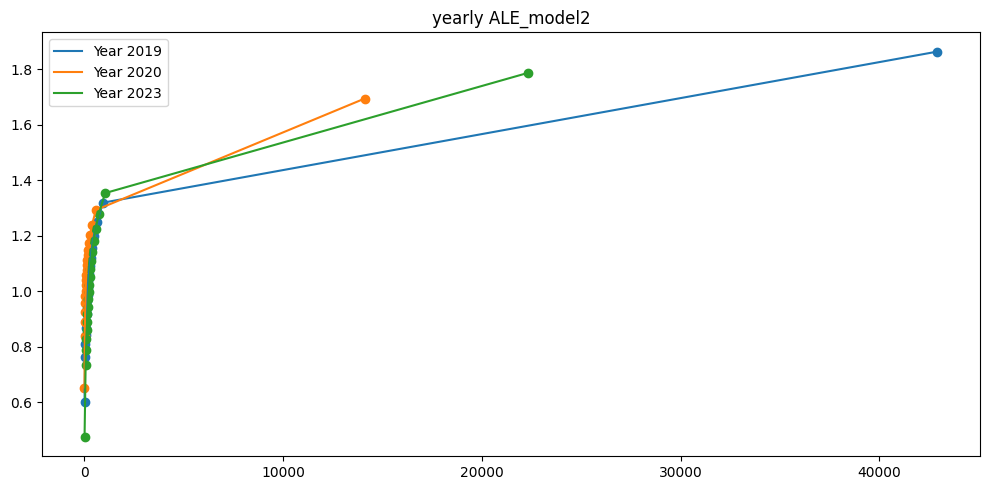

In [76]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(np.exp(quantiles[0])-1, np.exp(ale_19_1st), label='Year 2019')
ax.plot(np.exp(quantiles[1])-1, np.exp(ale_20_1st), label='Year 2020')
ax.plot(np.exp(quantiles[2])-1, np.exp(ale_23_1st), label='Year 2023')

ax.scatter(np.exp(quantiles[0])-1, np.exp(ale_19_1st))
ax.scatter(np.exp(quantiles[1])-1, np.exp(ale_20_1st))
ax.scatter(np.exp(quantiles[2])-1, np.exp(ale_23_1st))


# ax.set_ylim([-0.11,0.05])
ax.legend()

plt.title("yearly ALE_model2")
plt.tight_layout()
plt.show()

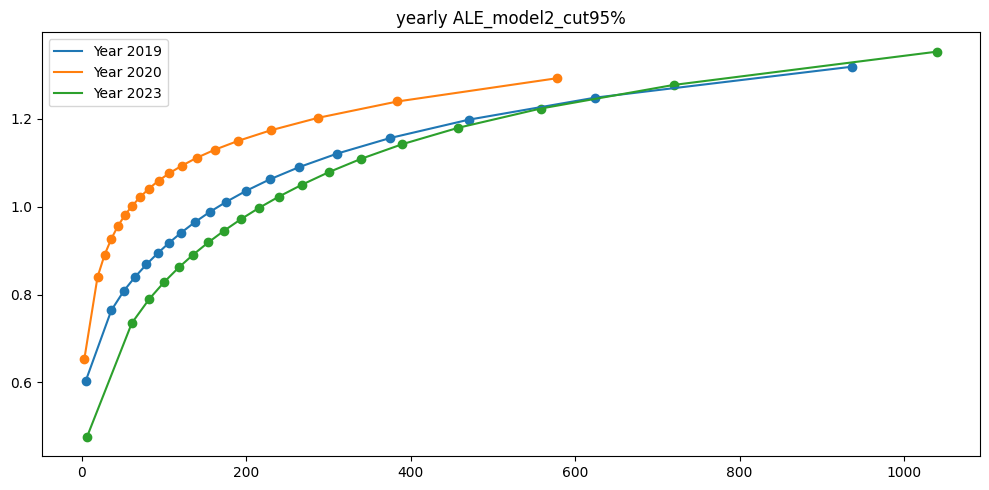

In [104]:
quantiles_cut = [row[:-1] for row in quantiles]
ale_19_1st_cut = ale_19_1st[:-1]
ale_20_1st_cut = ale_20_1st[:-1]
ale_23_1st_cut = ale_23_1st[:-1]

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(np.exp(quantiles_cut[0])-1, np.exp(ale_19_1st_cut), label='Year 2019')
ax.plot(np.exp(quantiles_cut[1])-1, np.exp(ale_20_1st_cut), label='Year 2020')
ax.plot(np.exp(quantiles_cut[2])-1, np.exp(ale_23_1st_cut), label='Year 2023')

ax.scatter(np.exp(quantiles_cut[0])-1, np.exp(ale_19_1st_cut))
ax.scatter(np.exp(quantiles_cut[1])-1, np.exp(ale_20_1st_cut))
ax.scatter(np.exp(quantiles_cut[2])-1, np.exp(ale_23_1st_cut))


# ax.set_ylim([-0.11,0.05])
ax.legend()

plt.title("yearly ALE_model2_cut95%")
plt.tight_layout()
plt.show()

In [99]:
# 计算ALER和ALED(基于全ALE数据)
ALER = []
ALED = []

ale_value_list = [ale_19_1st,ale_20_1st, ale_23_1st]
for i in range(3):  
    # Calculate ALER (min and max of ale_y)
    ale_y = ale_value_list[i]
    #counts = ale_n[i]

    aler = [np.min(np.exp(ale_y)), np.max(np.exp(ale_y))]
    ALER.append(aler)

    # Calculate ALED (mean absolute deviation of ale_y)
    #aled = np.sum(np.abs(ale_y) * counts * ale_range[i]) / np.sum(counts * ale_range[i])
    aled = np.mean(np.exp(ale_y))
    ALED.append(aled)


In [101]:
ALER

[[0.6021501767377712, 1.8627741677842133],
 [0.6537850353187529, 1.6935644239470897],
 [0.4756096102116511, 1.786224184729454]]

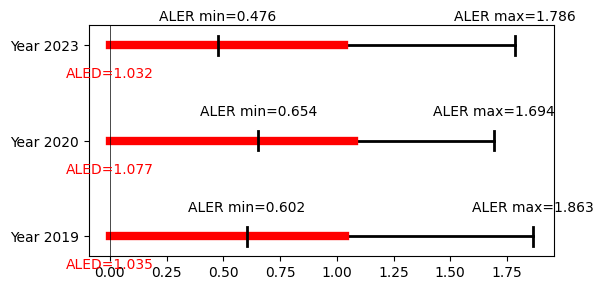

In [103]:
aler_2019, aler_2020, aler_2023 = ALER[0], ALER[1], ALER[2]
aled_2019, aled_2020, aled_2023 = ALED[0]/2, ALED[1]/2, ALED[2]/2

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(6, 3))

# Define the positions on the y-axis for each year
positions = [0, 1, 2]
years = ['Year 2019', 'Year 2020', 'Year 2023']

# Draw lines for ALER and ALED for each year
for pos, aler, aled in zip(positions, [aler_2019, aler_2020, aler_2023], [aled_2019, aled_2020, aled_2023]):
    ax.plot(aler, [pos, pos], color='black', lw=2)  # ALER line
    ax.plot([0, aled *2], [pos, pos], color='red', lw=6)  # ALED line segment
    ax.plot([aler[0], aler[0]], [pos - 0.1, pos + 0.1], color='black', lw=2)  # ALER left cap
    ax.plot([aler[1], aler[1]], [pos - 0.1, pos + 0.1], color='black', lw=2)  # ALER right cap
    # Annotate the ALED value at the center
    ax.annotate(f'ALED={aled*2:.3f}', xy=(0, pos), xytext=(0, pos - 0.3),
                ha='center', va='center', color='red')
    # Annotate the ALER range at the ends
    ax.annotate(f'ALER min={aler[0]:.3f}', xy=(aler[0], pos), xytext=(aler[0], pos + 0.3),
                ha='center', va='center')
    ax.annotate(f'ALER max={aler[1]:.3f}', xy=(aler[1], pos), xytext=(aler[1], pos + 0.3),
                ha='center', va='center')

ax.axvline(x=0,lw=0.5,c='black')
# Set y-axis to display years
ax.set_yticks(positions)
ax.set_yticklabels(years)

# Set limits for x-axis
# ax.set_xlim(-0.15, 0.05)

# Remove x-axis and ticks
# ax.xaxis.set_ticks([])

# # Hide the spines and x-axis
# for spine in ax.spines.values():
#     spine.set_visible(False)
# ax.xaxis.set_visible(False)

# Show the plot
plt.show()

In [123]:
#计算EALER（基于95%ALE数据，考虑是否用均值）
#先不用均值试下
#数值单位：变化倍数/变化百人

EALER = []
EALED = []

ale_value_list = [ale_19_1st_cut,ale_20_1st_cut, ale_23_1st_cut]
ale_value_exp_list = np.exp(ale_value_list)
quantiles_cut_exp = np.exp(quantiles_cut) - 1


for i in range(3):  
    # Calculate ALER (min and max of ale_y)
    ale_y = ale_value_exp_list[i]
    ale_y_bin0 = ale_y[0]
    quantile = quantiles_cut_exp[i]
    quantile_bin0 = quantile[0]
    
    delta_ale = np.abs(ale_y-ale_y_bin0)
    delta_ale = delta_ale[1:]
    
    delta_quantile = np.abs(quantile-quantile_bin0) / 100
    delta_quantile = delta_quantile[1:]
    
    eale_y = delta_ale / delta_quantile
    #counts = ale_n[i]

    ealer = [np.min(eale_y), np.max(eale_y)]
    EALER.append(ealer)

    # Calculate ALED (mean absolute deviation of ale_y)
    #aled = np.sum(np.abs(ale_y) * counts * ale_range[i]) / np.sum(counts * ale_range[i])
    ealed = np.mean(eale_y)
    EALED.append(ealed)

In [124]:
EALED, EALER

([0.2588561514683032, 0.4897520988438967, 0.2522961772136617],
 [[0.07692019088237954, 0.5166081658852995],
  [0.11124633375595726, 1.1632367384212563],
  [0.08486551068945612, 0.4754778823094516]])

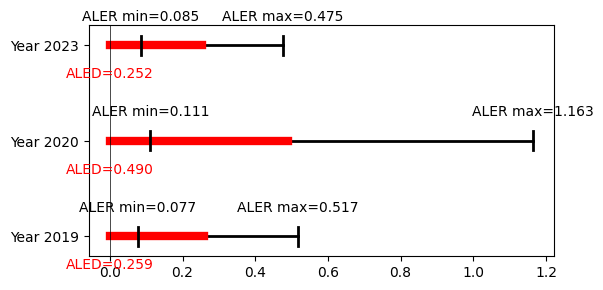

In [125]:
##EALER和EALED
aler_2019, aler_2020, aler_2023 = EALER[0], EALER[1], EALER[2]
aled_2019, aled_2020, aled_2023 = EALED[0]/2, EALED[1]/2, EALED[2]/2

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(6, 3))

# Define the positions on the y-axis for each year
positions = [0, 1, 2]
years = ['Year 2019', 'Year 2020', 'Year 2023']

# Draw lines for ALER and ALED for each year
for pos, aler, aled in zip(positions, [aler_2019, aler_2020, aler_2023], [aled_2019, aled_2020, aled_2023]):
    ax.plot(aler, [pos, pos], color='black', lw=2)  # ALER line
    ax.plot([0, aled *2], [pos, pos], color='red', lw=6)  # ALED line segment
    ax.plot([aler[0], aler[0]], [pos - 0.1, pos + 0.1], color='black', lw=2)  # ALER left cap
    ax.plot([aler[1], aler[1]], [pos - 0.1, pos + 0.1], color='black', lw=2)  # ALER right cap
    # Annotate the ALED value at the center
    ax.annotate(f'ALED={aled*2:.3f}', xy=(0, pos), xytext=(0, pos - 0.3),
                ha='center', va='center', color='red')
    # Annotate the ALER range at the ends
    ax.annotate(f'ALER min={aler[0]:.3f}', xy=(aler[0], pos), xytext=(aler[0], pos + 0.3),
                ha='center', va='center')
    ax.annotate(f'ALER max={aler[1]:.3f}', xy=(aler[1], pos), xytext=(aler[1], pos + 0.3),
                ha='center', va='center')

ax.axvline(x=0,lw=0.5,c='black')
# Set y-axis to display years
ax.set_yticks(positions)
ax.set_yticklabels(years)

# Set limits for x-axis
# ax.set_xlim(-0.15, 0.05)

# Remove x-axis and ticks
# ax.xaxis.set_ticks([])

# # Hide the spines and x-axis
# for spine in ax.spines.values():
#     spine.set_visible(False)
# ax.xaxis.set_visible(False)

# Show the plot
plt.show()

In [121]:
#计算EALER（基于95%ALE数据，考虑是否用均值）
#使用均值
#数值单位：变化千米/变化百人

EALER = []
EALED = []

avg_list = [7.8, 5.5, 7.3]

ale_value_list = [ale_19_1st_cut,ale_20_1st_cut, ale_23_1st_cut]
ale_value_exp_list = np.exp(ale_value_list)
quantiles_cut_exp = np.exp(quantiles_cut) - 1


for i in range(3):  
    # Calculate ALER (min and max of ale_y)
    ale_y = ale_value_exp_list[i]
    ale_y_bin0 = ale_y[0]
    quantile = quantiles_cut_exp[i]
    quantile_bin0 = quantile[0]
    
    avg = avg_list[i]
    
    delta_ale = np.abs(ale_y-ale_y_bin0) * avg
    delta_ale = delta_ale[1:]
    
    delta_quantile = np.abs(quantile-quantile_bin0) / 100
    delta_quantile = delta_quantile[1:]
    
    eale_y = delta_ale / delta_quantile
    #counts = ale_n[i]

    ealer = [np.min(eale_y), np.max(eale_y)]
    EALER.append(ealer)

    # Calculate ALED (mean absolute deviation of ale_y)
    #aled = np.sum(np.abs(ale_y) * counts * ale_range[i]) / np.sum(counts * ale_range[i])
    ealed = np.mean(eale_y)
    EALED.append(ealed)

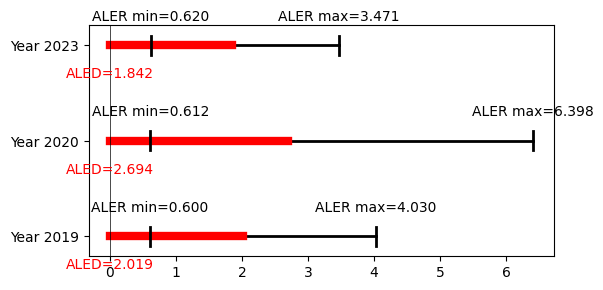

In [122]:
##EALER和EALED
aler_2019, aler_2020, aler_2023 = EALER[0], EALER[1], EALER[2]
aled_2019, aled_2020, aled_2023 = EALED[0]/2, EALED[1]/2, EALED[2]/2

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(6, 3))

# Define the positions on the y-axis for each year
positions = [0, 1, 2]
years = ['Year 2019', 'Year 2020', 'Year 2023']

# Draw lines for ALER and ALED for each year
for pos, aler, aled in zip(positions, [aler_2019, aler_2020, aler_2023], [aled_2019, aled_2020, aled_2023]):
    ax.plot(aler, [pos, pos], color='black', lw=2)  # ALER line
    ax.plot([0, aled *2], [pos, pos], color='red', lw=6)  # ALED line segment
    ax.plot([aler[0], aler[0]], [pos - 0.1, pos + 0.1], color='black', lw=2)  # ALER left cap
    ax.plot([aler[1], aler[1]], [pos - 0.1, pos + 0.1], color='black', lw=2)  # ALER right cap
    # Annotate the ALED value at the center
    ax.annotate(f'ALED={aled*2:.3f}', xy=(0, pos), xytext=(0, pos - 0.3),
                ha='center', va='center', color='red')
    # Annotate the ALER range at the ends
    ax.annotate(f'ALER min={aler[0]:.3f}', xy=(aler[0], pos), xytext=(aler[0], pos + 0.3),
                ha='center', va='center')
    ax.annotate(f'ALER max={aler[1]:.3f}', xy=(aler[1], pos), xytext=(aler[1], pos + 0.3),
                ha='center', va='center')

ax.axvline(x=0,lw=0.5,c='black')
# Set y-axis to display years
ax.set_yticks(positions)
ax.set_yticklabels(years)

# Set limits for x-axis
# ax.set_xlim(-0.15, 0.05)

# Remove x-axis and ticks
# ax.xaxis.set_ticks([])

# # Hide the spines and x-axis
# for spine in ax.spines.values():
#     spine.set_visible(False)
# ax.xaxis.set_visible(False)

# Show the plot
plt.show()

### 2.3 rmsn_add_ent_model_optimal_v2_use_confounders_False

In [78]:
# 将三张ALE画在一起（用同一颜色条）
ale_19 = np.load("../data/result_data/week_ale_2019_add_ent_optimal_v2.npy")
ale_20 = np.load("../data/result_data/week_ale_2020_add_ent_optimal_v2.npy")
ale_23 = np.load("../data/result_data/week_ale_2023_add_ent_optimal_v2.npy")

In [79]:
# 将数组连接在一起
combined_array = np.concatenate([ale_19,ale_23])

# 找出最小值和最大值
min_val = np.min(combined_array)
max_val = np.max(combined_array)
midpoint = abs(min_val) / (abs(max_val) + abs(min_val))

colors = [(0, "blue"), (midpoint, "white"), (1, "red")]
linear_cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", colors)

Text(0.5, 1.0, 'Heatmap_model3')

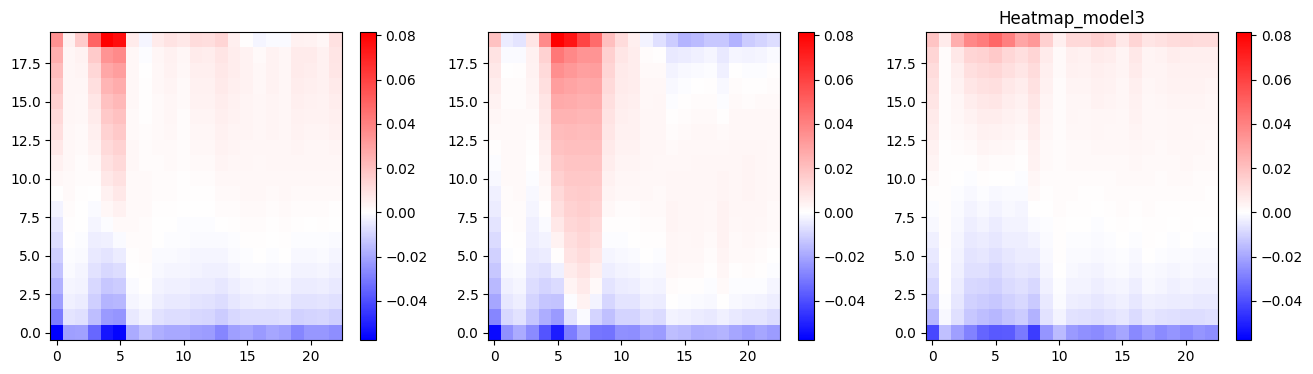

In [80]:
fig, ax = plt.subplots(1,3,figsize=(16,4))
HM_2019 = ax[0].imshow(ale_19.T, aspect='auto', cmap=linear_cmap, origin='lower', vmin=min_val, vmax=max_val)
HM_2020 = ax[1].imshow(ale_20.T, aspect='auto', cmap=linear_cmap, origin='lower', vmin=min_val, vmax=max_val)
HM_2023 = ax[2].imshow(ale_23.T, aspect='auto', cmap=linear_cmap, origin='lower', vmin=min_val, vmax=max_val)
fig.colorbar(HM_2019)
fig.colorbar(HM_2020)
fig.colorbar(HM_2023)
plt.title("Heatmap_model3")

In [81]:
quantiles =[[1.6942899, 3.604688, 3.9550974, 4.1904836, 4.3753552, 4.5325994, 4.673237, 4.8040957, 4.929389, 5.0522227, 5.175479, 5.301791, 5.435109, 5.5802326, 5.7425194, 5.9301834, 6.155841, 6.4387674, 6.8431473, 10.6669035],
           [1.3919743, 2.9971027, 3.3512206, 3.6021075, 3.8045802, 3.9785473, 4.1340814, 4.27761, 4.4141173, 4.5467253, 4.677453, 4.8095093, 4.9464726, 5.0927362, 5.254286, 5.44032, 5.6650457, 5.9527235, 6.360175, 9.553446],
           [1.9707608, 4.1234283, 4.4188213, 4.618977, 4.778722, 4.916623, 5.0410566, 5.1569986, 5.267918, 5.3763404, 5.4842725, 5.5940084, 5.7085733, 5.8315067, 5.9683475, 6.1289196, 6.326209, 6.580548, 6.94853, 10.013065],
           ]
ale_19_1st = np.sum(ale_19, axis=0)
ale_20_1st = np.sum(ale_20, axis=0)
ale_23_1st = np.sum(ale_23, axis=0)

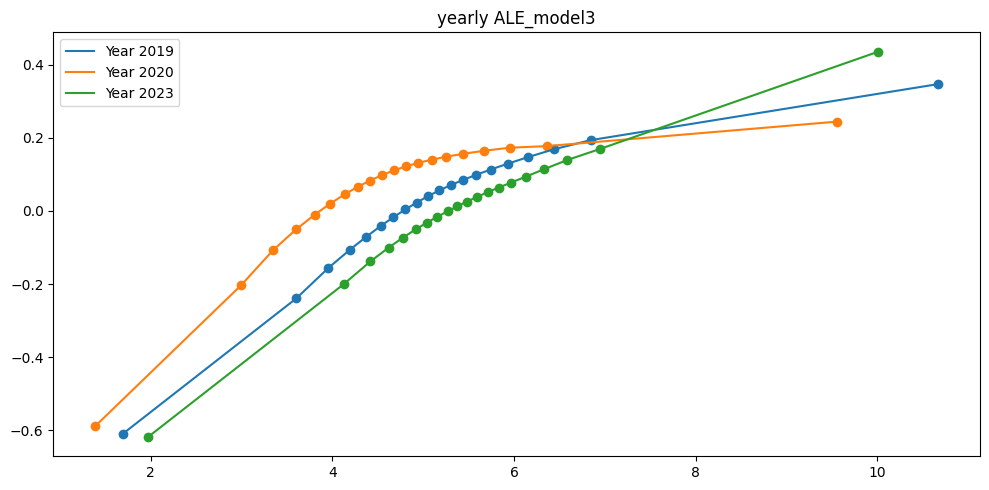

In [82]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(quantiles[0], ale_19_1st, label='Year 2019')
ax.plot(quantiles[1], ale_20_1st, label='Year 2020')
ax.plot(quantiles[2], ale_23_1st, label='Year 2023')

ax.scatter(quantiles[0], ale_19_1st)
ax.scatter(quantiles[1], ale_20_1st)
ax.scatter(quantiles[2], ale_23_1st)


# ax.set_ylim([-0.11,0.05])
ax.legend()

plt.title("yearly ALE_model3")
plt.tight_layout()
plt.show()

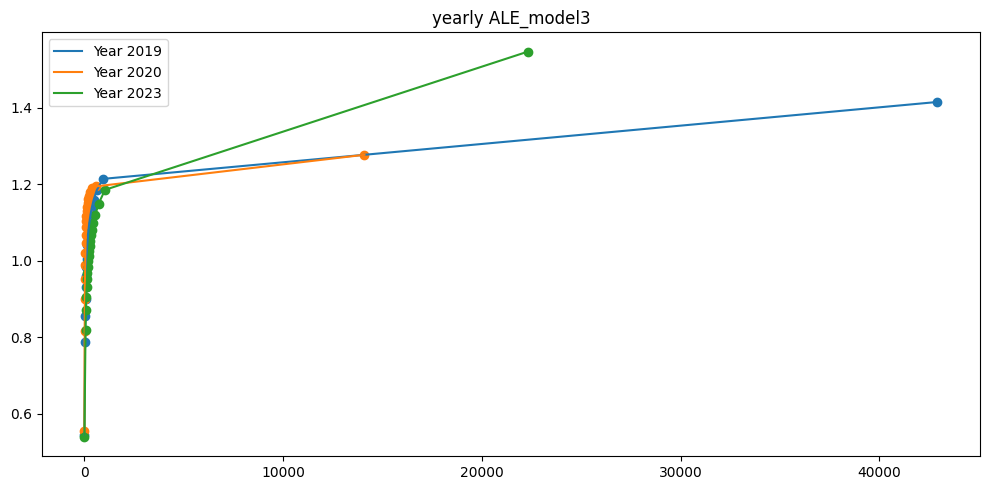

In [83]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(np.exp(quantiles[0])-1, np.exp(ale_19_1st), label='Year 2019')
ax.plot(np.exp(quantiles[1])-1, np.exp(ale_20_1st), label='Year 2020')
ax.plot(np.exp(quantiles[2])-1, np.exp(ale_23_1st), label='Year 2023')

ax.scatter(np.exp(quantiles[0])-1, np.exp(ale_19_1st))
ax.scatter(np.exp(quantiles[1])-1, np.exp(ale_20_1st))
ax.scatter(np.exp(quantiles[2])-1, np.exp(ale_23_1st))


# ax.set_ylim([-0.11,0.05])
ax.legend()

plt.title("yearly ALE_model3")
plt.tight_layout()
plt.show()

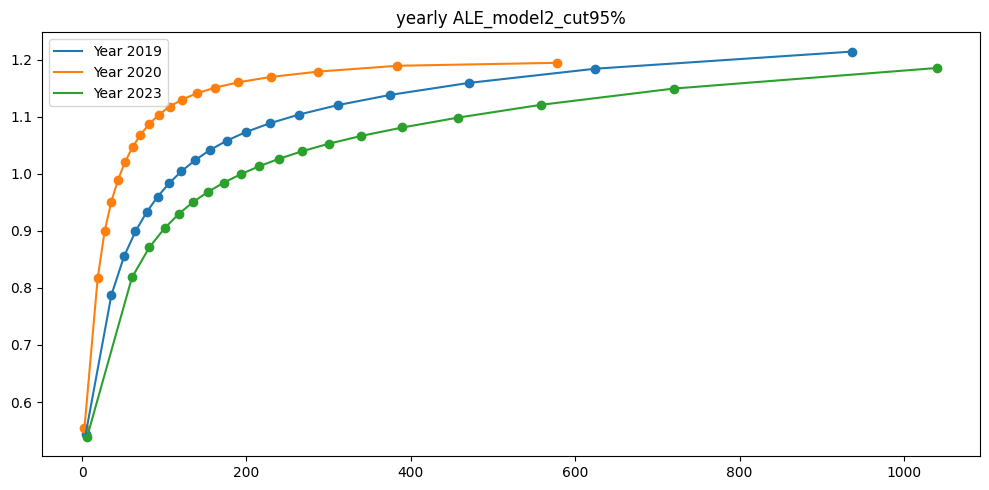

In [84]:
quantiles_cut = [row[:-1] for row in quantiles]
ale_19_1st_cut = ale_19_1st[:-1]
ale_20_1st_cut = ale_20_1st[:-1]
ale_23_1st_cut = ale_23_1st[:-1]

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(np.exp(quantiles_cut[0])-1, np.exp(ale_19_1st_cut), label='Year 2019')
ax.plot(np.exp(quantiles_cut[1])-1, np.exp(ale_20_1st_cut), label='Year 2020')
ax.plot(np.exp(quantiles_cut[2])-1, np.exp(ale_23_1st_cut), label='Year 2023')

ax.scatter(np.exp(quantiles_cut[0])-1, np.exp(ale_19_1st_cut))
ax.scatter(np.exp(quantiles_cut[1])-1, np.exp(ale_20_1st_cut))
ax.scatter(np.exp(quantiles_cut[2])-1, np.exp(ale_23_1st_cut))


# ax.set_ylim([-0.11,0.05])
ax.legend()

plt.title("yearly ALE_model2_cut95%")
plt.tight_layout()
plt.show()

### 2.4 三个模型之间比较

In [91]:
ale = np.load("../data/result_data/week_ale_2020_deconfound.npy")
ale_2020_model1 = np.sum(ale, axis=0)
quantiles_model1 = [1.3919743, 2.9971027, 3.3512206, 3.6021075, 3.8045802, 3.9785473, 4.1340814, 4.27761, 4.4141173, 4.5467253, 4.677453, 4.8095093, 4.9464726, 5.0927362, 5.254286, 5.44032, 5.6650457, 5.9527235, 6.360175, 9.553446]

ale_20 = np.load("../data/result_data/week_ale_2020_base_optimal_v2.npy")
ale_2020_model2 = np.sum(ale_20, axis=0)
quantiles_model2 =[1.3919743, 2.9971027, 3.3512206, 3.6021075, 3.8045802, 3.9785473, 4.1340814, 4.27761, 4.4141173, 4.5467253, 4.677453, 4.8095093, 4.9464726, 5.0927362, 5.254286, 5.44032, 5.6650457, 5.9527235, 6.360175, 9.553446]


ale_20 = np.load("../data/result_data/week_ale_2020_add_ent_optimal_v2.npy")
ale_2020_model3 = np.sum(ale_20, axis=0)
quantiles_model3 =[1.3919743, 2.9971027, 3.3512206, 3.6021075, 3.8045802, 3.9785473, 4.1340814, 4.27761, 4.4141173, 4.5467253, 4.677453, 4.8095093, 4.9464726, 5.0927362, 5.254286, 5.44032, 5.6650457, 5.9527235, 6.360175, 9.553446]


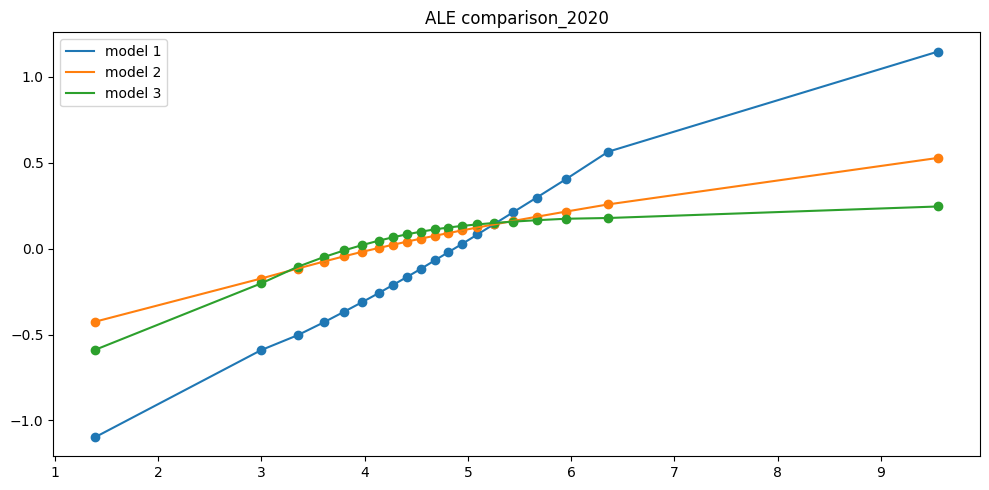

In [88]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(quantiles_model1, ale_2020_model1, label='model 1')
ax.plot(quantiles_model2, ale_2020_model2, label='model 2')
ax.plot(quantiles_model3, ale_2020_model3, label='model 3')

ax.scatter(quantiles_model1, ale_2020_model1)
ax.scatter(quantiles_model2, ale_2020_model2)
ax.scatter(quantiles_model3, ale_2020_model3)


# ax.set_ylim([-0.11,0.05])
ax.legend()

plt.title("ALE comparison_2020")
plt.tight_layout()
plt.show()

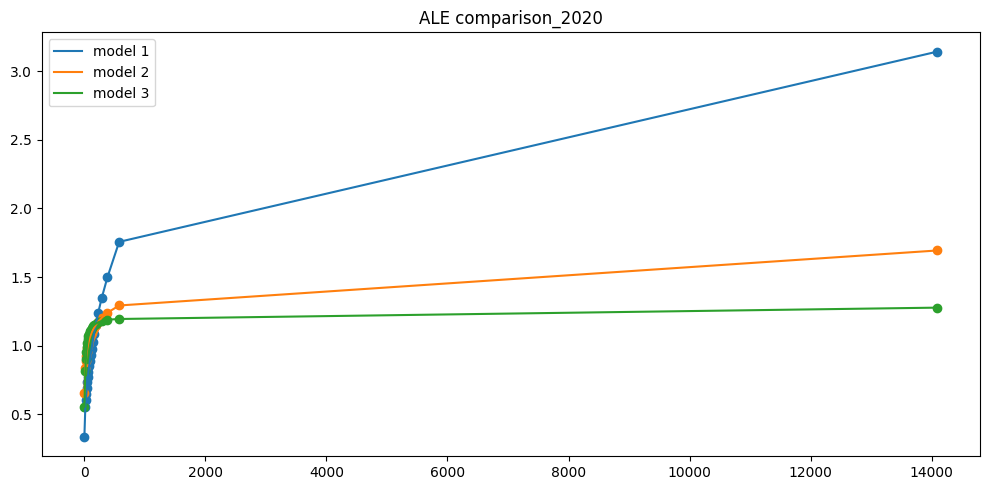

In [89]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(np.exp(quantiles_model1)-1, np.exp(ale_2020_model1), label='model 1')
ax.plot(np.exp(quantiles_model2)-1, np.exp(ale_2020_model2), label='model 2')
ax.plot(np.exp(quantiles_model3)-1, np.exp(ale_2020_model3), label='model 3')

ax.scatter(np.exp(quantiles_model1)-1, np.exp(ale_2020_model1))
ax.scatter(np.exp(quantiles_model2)-1, np.exp(ale_2020_model2))
ax.scatter(np.exp(quantiles_model3)-1, np.exp(ale_2020_model3))


# ax.set_ylim([-0.11,0.05])
ax.legend()

plt.title("ALE comparison_2020")
plt.tight_layout()
plt.show()

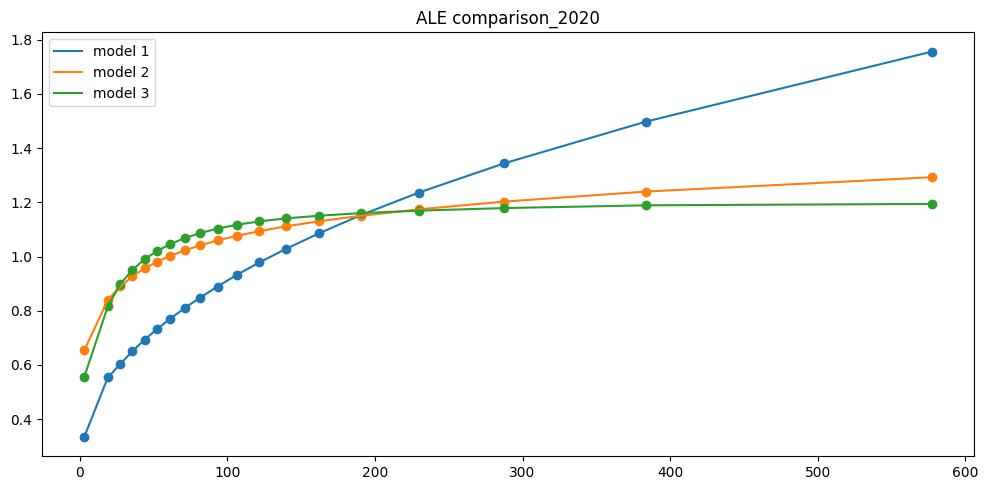

In [92]:
quantiles_model1_cut=quantiles_model1[:-1]
quantiles_model2_cut=quantiles_model2[:-1]
quantiles_model3_cut=quantiles_model3[:-1]
ale_2020_model1_cut=ale_2020_model1[:-1]
ale_2020_model2_cut=ale_2020_model2[:-1]
ale_2020_model3_cut=ale_2020_model3[:-1]

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(np.exp(quantiles_model1_cut)-1, np.exp(ale_2020_model1_cut), label='model 1')
ax.plot(np.exp(quantiles_model2_cut)-1, np.exp(ale_2020_model2_cut), label='model 2')
ax.plot(np.exp(quantiles_model3_cut)-1, np.exp(ale_2020_model3_cut), label='model 3')

ax.scatter(np.exp(quantiles_model1_cut)-1, np.exp(ale_2020_model1_cut))
ax.scatter(np.exp(quantiles_model2_cut)-1, np.exp(ale_2020_model2_cut))
ax.scatter(np.exp(quantiles_model3_cut)-1, np.exp(ale_2020_model3_cut))


# ax.set_ylim([-0.11,0.05])
ax.legend()

plt.title("ALE comparison_2020")
plt.tight_layout()
plt.show()